## Extender lógicas de limpieza utilizando Random Forest

### 1.Introducción
Existen técnicas de machine learning que dan buenos resultados detectando anomalías y que puede resultar útiles de implementar en procesos de limpieza de datos. Sin embargo, ¿Es un análisis estático o puede extrapolarse a registros nuevos?¿Es una metodología lo suficientemente robusta como para ser implementada en producción?. En este notebook se revisará cómo se comportan estos modelos con la entrada de nuevos registros y alternativas para replicar la lógica de limpieza.

### 2.¿Qué Random Forest?
Es un modelo que modifica el bagging tradicional de árboles de decisión y le agrega componentes de aleatoriedad en la selección de variables. De esta forma, cada arbol es entrenado con un subconjunto de variables seleccionadas de forma aleatoria y con un set de registros también aleatorio. El resultado de esto es un un conjunto de arboles entrenados de forma independiente e imparcial, los cuales son promediados y así se reduce la variación existente entre los modelos. El resultado de esta técnica es un modelo que tiene mejores resultados respecto a un arbol simple o bagging mediante sampling de registros.


### 3.¿Por qué usarlo?
- Es un modelo sencillo de entrenar y produce muy buenos resultaltados, sobretodo en datasets medianos/grandes.
- La apertura de la interacción de las variables puede dar luces de la interacción e importancia de las variables.
- Menor nivel de overfitting respecto a un arbol de decisión


Fuentes

- https://www.aprendemachinelearning.com/random-forest-el-poder-del-ensamble/
- Material del curso The Power of Random dictado por Dean Abbott en KNIME Summit Spring 2019
- https://quantdare.com/random-forest-vs-simple-tree/

### 3. Probando el algoritmo

#### 3.1 Creando el Dataset
Lo primero será tener un dataset de prueba, para ello se utilizarán los generadores de datos diponibles en [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#samples-generator). En este caso se quiere probar la performance de los modelos con bases de gran tamaño, de modo que se construirá un dataset compuesto por 25 millones de registros y 20 columnas.

In [36]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import hdbscan
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

In [10]:
blobs, labels = make_blobs(n_samples=25000000, n_features=20,centers=10,random_state=9)

nfeatures_original=pd.DataFrame(blobs)
l=pd.DataFrame(data=labels,columns=["label"])
l['label']=l['label'].apply(lambda x: "Label_"+str(x))
nfeatures_original=nfeatures_original.join(l)
nfeatures_original.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,-1.180987,1.240578,3.020975,-1.746975,-0.291096,-2.836429,1.910870,-0.688452,-1.341357,0.386906,0.282403,2.045138,1.381275,-2.368303,0.165511,0.479028,2.622244,1.431891,-0.094469,0.008586
std,5.660561,5.552799,4.825853,5.399640,7.367955,5.247887,4.684554,5.646922,5.638823,7.233953,3.700956,4.185818,5.575288,6.238378,5.164511,6.766531,4.103338,5.340570,5.054180,4.395648
min,-14.026723,-13.762399,-9.373089,-13.751342,-13.526813,-14.019405,-10.934058,-12.046078,-12.918819,-13.407943,-11.266958,-8.417818,-12.521822,-13.408967,-13.518929,-13.355585,-9.117708,-12.643270,-13.866750,-11.090146
25%,-5.085020,-0.745230,-0.944357,-5.986434,-7.144318,-7.149665,-1.749823,-5.825424,-6.363767,-7.540214,-3.102793,-1.834611,-2.290033,-7.429729,-4.571022,-6.720977,-0.077673,-0.950104,-3.070485,-3.091744
50%,-1.278812,2.378955,5.082070,-1.781434,-2.384345,-3.957533,2.681590,-1.544589,-1.406795,0.206154,1.544931,2.784781,1.576957,-4.869856,1.505666,2.887753,2.673839,2.373062,0.620384,-0.392320
75%,2.676867,5.871548,6.934630,0.660719,7.767558,0.182053,5.039391,4.071191,2.015313,7.861989,3.256303,5.679863,5.122707,3.718944,4.295971,6.845691,5.942965,5.311248,3.518761,4.029159
max,13.556880,11.365369,12.875444,13.932041,13.317516,10.508688,13.945744,12.866711,12.837818,13.992286,8.164877,12.039185,13.975856,14.084059,11.620537,12.714821,12.484557,12.841678,11.263108,10.297150


De manera adicional, se agregarán 200 registros aleatorios para ensuciar un poco los datos originales

In [63]:
adicionales=[]
for i in range(0,200):
    punto=[]
    for j in range(0,(len(nfeatures_original.columns)-1)):
        ran=( 1+random.uniform(0, 1))*random.randrange(round(nfeatures_original[j].min(),0), round(nfeatures_original[j].max(),0))+random.uniform(0, 1)
        punto.append(ran)
    
    adicionales.append(punto)
    
ad=pd.DataFrame(adicionales)
ad['label']='outlier'
nfeatures_real= nfeatures_original.append(ad) 

nfeatures_real['es_outlier']=nfeatures_real['label'].apply(lambda x: 1 if x =='outlier' else 0)

In [56]:
features=[x for x in range(0,20)]

#### 3.1 Test de Isolation Forest: Qué reviente la máquina

Ahora que tenemos un dataset de gran tamaño, lo primero es probar el algoritmo Isolation Forest con todos los datos disponibles para así tener noción de cuánto tiempo se demora en ejecutar. Así se podrá descartar/aprobar el uso de esa ténica con gran volumen de datos.

In [27]:
startTime = datetime.now()
isolation=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12),max_features=1.0, n_jobs=-1, random_state=42, verbose=0)
isolation.fit(nfeatures_real[features])
pred = isolation.predict(nfeatures_real[features])
endtime= datetime.now() 

nfeatures_real['isolation']= pred

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [28]:
 print("Tiempo de ejecución: ", endtime- startTime)

Tiempo de ejecución:  0:00:58.510841


#### 3.2 Performance usando una muestra del dataset

Si bien el modelo pudo procesar los 25 millones de registros en apenas 1 minuto, aún queda pendiente validar si es factible tomar una pequeña muestra para entrenar y luego extrapolar al dataset completo. Para esto se usará una muestra de 1 millón de registros seleccionados aleatoriamente.Se entrenará un Isolation forest con esta muestra y luego se usará este modelo para predecir el resultado de los otros 24 millones de registros.

In [64]:
nfeatures_real_s=resample(nfeatures_real, n_samples=1000000)

In [68]:
isolation3=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12),max_features=1.0, n_jobs=-1, random_state=42, verbose=0)
isolation3.fit(nfeatures_real_s[features])

pred = isolation.predict(nfeatures_real_s[features])
endtime= datetime.now() 

nfeatures_real_s['isolation']= pred

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Considerando que:

 - Alternativa 1: Entrenar I.F con todo el dataset
 - Alternativa 2: Entrenar I.F con una muestra y luego extrapolar a todo el dataset
 
 Si bien la alternativa 1 finalizó en un tiempo de ejecución aceptable, no tuvo buenos resultados clasificando los valores. La gran parte de los valores atípicos que detectó corresponden a registros válidos de otras categorías. No así la alternativa 2, que concentra la mayor cantidad de atípicos en los registros de ruido que se insertaron originalmente.
 
 

Text(0.5, 0, 'Isolation en 1M')

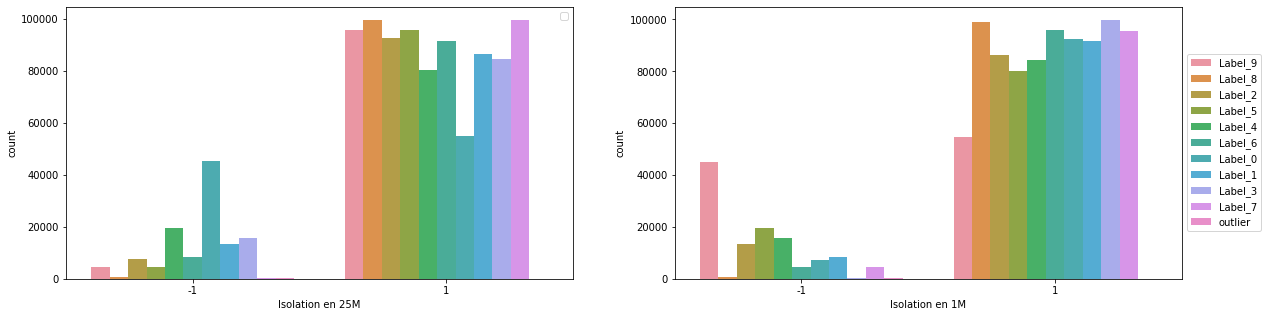

In [61]:
f=plt.figure(figsize=(20, 5))

gs = plt.GridSpec(1,2,f,hspace=0.5)

plt.subplot(gs[0,0])
ax=sns.countplot(data=nfeatures_real,x='isolation',hue='label')
plt.legend('')  
ax.set_xlabel('Isolation en 25M')

plt.subplot(gs[0,1])
ax1=sns.countplot(data=nfeatures_real_s,x='isolation',hue='label')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_xlabel('Isolation en 1M')

#### 3.3 Extrapolando con un Random Forest.

Hasta este punto se ha mostrado que una buena alternativa es samplear los datos originales para obtener un Isolation Forest entrenado y luego utilizar este para obtener la limpieza de todos los registros. Considerando dicho contexto, se tiene un dataset clasificado en 2 tipos (atípico/no-atípico) y se necesita validar que ocurre en otro conjunto de información, lo descrito anteriormente es muy similar a resolver un problema de clasificación tradicional, de modo que puede ser atractivo probar modelos de alta eficiencia en sitaciones de este tipo. En esta tercera etapa se comparará la precisión del I.F extendido con un Random Forest.El objetivo es ver cual de las dos alternativas es más certeza en detectar los datos aleatorios inyectados de forma artificial

In [70]:
nfeatures_real_s['isolation']=nfeatures_real_s['isolation'].apply(lambda x: 0 if x==1 else 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
x_train, x_test, y_train, y_test = train_test_split( nfeatures_real_s[features], nfeatures_real_s['isolation'], test_size=0.8, random_state=42)

In [72]:
random_forest = RandomForestClassifier(n_jobs=2, random_state=0)

In [73]:
random_forest.fit(x_train,y_train)
accuracy=accuracy_score(y_test, random_forest.predict(x_test))
accuracy

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.93104125

In [74]:
accuracy=accuracy_score(nfeatures_real['es_outlier'], random_forest.predict(nfeatures_real[features]))
accuracy

0.928252349530094

In [76]:
pred = isolation3.predict(nfeatures_real[features])
endtime= datetime.now() 
nfeatures_real['isolation_proyectado']= pred
nfeatures_real['isolation_proyectado']=nfeatures_real['isolation_proyectado'].apply(lambda x: 0 if x==1 else 1)



/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0.0

In [77]:
accuracy=accuracy_score(nfeatures_real['es_outlier'], nfeatures_real['isolation_proyectado'])
accuracy

0.8794281143771245